# stepAIC - Stepwise and Lasso linear regression to minimize AIC or BIC

**Example of stepwise and Lasso linear regression to minimize AIC or BIC**

The stepAIC package includes two functions, **stepwise** and **lasso**, to find the optimum set of predictor variables that minimizes either the Akaike Information Criterion (AIC, default) or Bayesian Information Criterion (BIC, optional) in a linear regression model.

### Stepwise

The **stepwise** function in the stepAIC package has the option to use either forward selection (default), backward selection, or all combinations for the optimum set of predictor variables as follows:

- Forward selection (default) starts with no predictors and adds predictors as long as it improves the model (reduces AIC or BIC) 
- Backward selection starts with all predictors and removes predictors as long as it improves the model (reduces AIC or BIC)
- All possible combinations of predictors to find the best of all possible models (up to 20 candidate predictors)

The stepwise algorithm also has the option (default) to remove any non-signficant predictors (p-values below a user-specified p_threshold with default p_threshold=0.05) after either a forward or backward search. 

### Lasso

The **lasso** function in the stepAIC package provides output of regression models and summary statistics using the following four methods from the sklearn.linear_model package:

- LassoCV: Lasso using Cross-Validation with coordinate descent  
- LassoLarsCV: Lasso using Cross-Validation with Least Angle Regression
- LassoLarsIC using AIC: Lasso using Least Angle Regression with Akaike Information Criterion
- LassoLarsIC using BIC: Lasso using Least Angle Regression with Bayesian Information Criterion

Lasso regression is a linear regression method that includes a penalty term to the standard least squares objective function. The penalty term is a sum of the absolute values of the regression coefficients multiplied by a hyperparameter, denoted as "alpha". The **lasso** function finds the optimum value of alpha for each of the four different methods methods listed above. The alpha determines the amount of shrinkage applied to the model coefficients. As alpha increases, the coefficients are pushed towards zero, and some may become exactly zero, effectively eliminating those features from the model. 

### AIC vs BIC

Using AIC as the criterion is the default in the stepAIC fuction. The user also has the option to use the BIC as the criterion instead. AIC is considered to be a useful critierion in stepwise regression. However, BIC is generally considered to be better than AIC for several reasons:

- Penalty for Complexity: BIC penalizes models more heavily for the number of parameters, making it more conservative and less likely to overfit, especially with larger sample sizes.
- Model Selection: BIC is particularly useful when the sample size is large, as it encourages simpler models that are less likely to capture noise.
- Model Recovery: Studies suggest that BIC tends to recover the true model more effectively than AIC, particularly in scenarios where the sample size is large.
While both criteria are useful for model selection, BIC is often preferred for its stricter criteria, which helps in avoiding overfitting and improving model interpretability

In this example we will use the concrete.csv dataset from HW1 and HW2 of UW CEE 415 Machine Learning

## Install and import the packages that are needed

In [1]:
# # Run the following commands to install stepAIC for the first time
# !pip install git+https://github.com/gjpelletier/stepAIC.git

# # Run the following commands to upgrade stepAIC to the latest versions
# !pip install git+https://github.com/gjpelletier/stepAIC.git --upgrade

In [2]:
from stepAIC import stepwise, lasso
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load and clean the data set

In [3]:
# import the dataset
df = pd.read_csv("concrete.csv")
print(df.head())

   attr_1  attr_2  attr_3  attr_4  attr_5  attr_6  attr_7  attr_8  strength
0   141.3   212.0     0.0   203.5     0.0   971.8   748.5      28     29.89
1   168.9    42.2   124.3   158.3    10.8  1080.8   796.2      14     23.51
2   250.0     0.0    95.7   187.4     5.5   956.9   861.2      28     29.22
3   266.0   114.0     0.0   228.0     0.0   932.0   670.0      28     45.85
4   154.8   183.4     0.0   193.3     9.1  1047.4   696.7      28     18.29


In [4]:
# load the description file
headers = json.load(open('data_column_description.txt'))
headers

{'attr_1': 'cement',
 'attr_2': 'slag',
 'attr_3': 'fly_ash',
 'attr_4': 'water',
 'attr_5': 'superplasticizer',
 'attr_6': 'coarse_aggregate',
 'attr_7': 'fine_aggregate',
 'attr_8': 'age'}

In [5]:
# rename the columns
df.rename(columns = headers,
inplace = True)
print(df.head())
print("The columns have been renamed.")

   cement   slag  fly_ash  water  superplasticizer  coarse_aggregate  \
0   141.3  212.0      0.0  203.5               0.0             971.8   
1   168.9   42.2    124.3  158.3              10.8            1080.8   
2   250.0    0.0     95.7  187.4               5.5             956.9   
3   266.0  114.0      0.0  228.0               0.0             932.0   
4   154.8  183.4      0.0  193.3               9.1            1047.4   

   fine_aggregate  age  strength  
0           748.5   28     29.89  
1           796.2   14     23.51  
2           861.2   28     29.22  
3           670.0   28     45.85  
4           696.7   28     18.29  
The columns have been renamed.


In [6]:
# report the shape of the dataset
print("There are {0} rows and {1} columns in the dataset".format(df.shape[0],df.shape[1]))

There are 1030 rows and 9 columns in the dataset


In [7]:
# # check duplicated rows
print("There are {} duplicated rows in the dataset".format(df.duplicated().sum()))

There are 25 duplicated rows in the dataset


In [8]:
# drop duplicates and missing values and print the shape again
df.drop_duplicates(inplace=True)
print("There are {0} rows and {1} columns in the dataset after removing the duplicated rows"
      .format(df.shape[0],df.shape[1]))

There are 1005 rows and 9 columns in the dataset after removing the duplicated rows


In [9]:
# clean the data by dropping rows with nan
df = df.dropna()
print("There are {0} rows and {1} columns in the dataset after removing the rows with nan values"
      .format(df.shape[0],df.shape[1]))

# # optional - fill missing data with mean or median
# # df['column_name'].fillna(df['column_name'].mean(), inplace=True)
# for column in df.columns:
#     df[column].fillna(df[column].mean(), inplace=True)

There are 1005 rows and 9 columns in the dataset after removing the rows with nan values


## Check a description, histograms, and correlation matrix of the data set

In [10]:
# describe the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1005.0,278.631343,104.344261,102.00,190.70,265.0,349.00,540.0
slag,1005.0,72.043483,86.170807,0.00,0.00,20.0,142.50,359.4
fly_ash,1005.0,55.536318,64.207969,0.00,0.00,0.0,118.30,200.1
water,1005.0,182.075323,21.339334,121.80,166.60,185.7,192.90,247.0
superplasticizer,1005.0,6.033234,5.919967,0.00,0.00,6.1,10.00,32.2
coarse_aggregate,1005.0,974.376816,77.579667,801.00,932.00,968.0,1031.00,1145.0
fine_aggregate,1005.0,772.688259,80.340435,594.00,724.30,780.0,822.20,992.6
age,1005.0,45.856716,63.734692,1.00,7.00,28.0,56.00,365.0
strength,1005.0,35.250378,16.284815,2.33,23.52,33.8,44.87,82.6


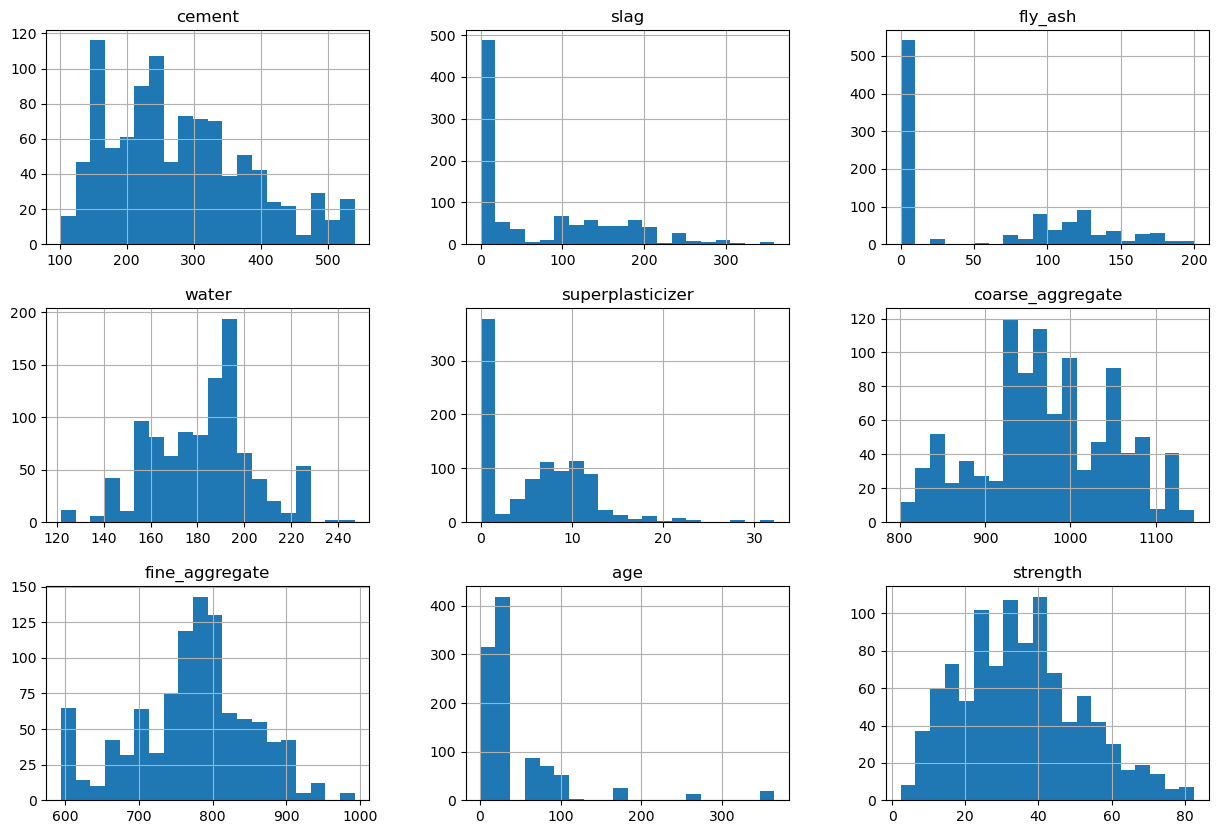

In [11]:
# show histrograms of the data
df.hist(bins=20, figsize=(15, 10));

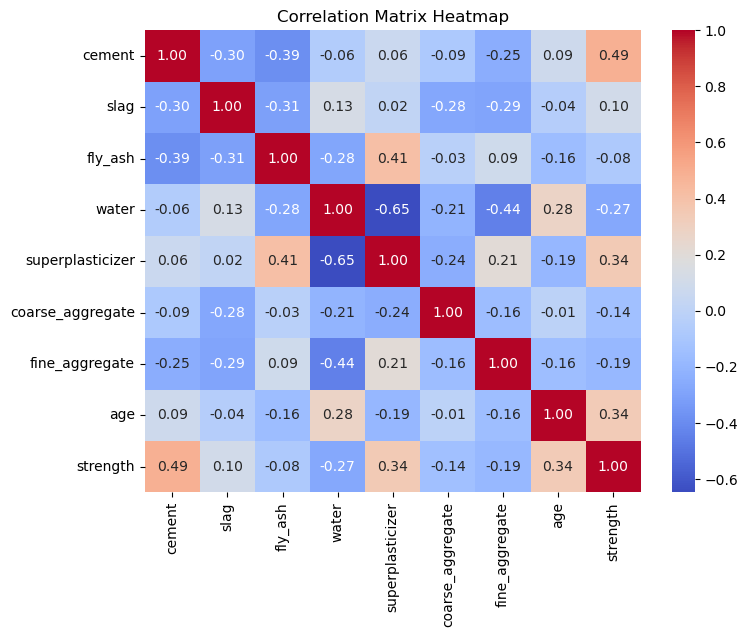

In [12]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [13]:
# Show which variables are potentially the most correlated predictors of strength
print('The following variables are potentially the most influential \n based on having absolute values of correlation coefficients >= 0.2:')
correlation_matrix['strength'][abs(correlation_matrix['strength'])>=.2]

The following variables are potentially the most influential 
 based on having absolute values of correlation coefficients >= 0.2:


cement              0.488283
water              -0.269624
superplasticizer    0.344209
age                 0.337367
strength            1.000000
Name: strength, dtype: float64

## Split the data set into the response variable (strength) and the candidate predictor variables

In [14]:
# Split the dataset into independent (X) and dependent (y) variables
X = df.drop(['strength'], axis = 1)
y = df['strength']

## Variance Inflation Factors of candidate predictors

In the next section we will use Variance Inflation Factors (VIF) to evaluate collinearity of all possible predictors. VIF values greater than 5 indicate excessive collinearity.

In [15]:
# Variance Inflation Factors of predictor variables
# VIF>5 indicates unacceptable collinearity
# Try dropping predictors that are most correlated with other predictors
# until all VIF values of the predictors are < 2

# import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant for the intercept
X_ = sm.add_constant(X)    

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X_.columns
vif["VIF"] = [variance_inflation_factor(X_.values, i)
                    for i in range(len(X_.columns))]

print('VIF of independent variables included in the final model:')
print('VIF<5 indicates acceptable collinearity')
vif

VIF of independent variables included in the final model:
VIF<5 indicates acceptable collinearity


,Feature,VIF
0,const,6622.874767
1,cement,7.448990
2,slag,7.263275
3,fly_ash,6.084539
4,water,6.838492
5,superplasticizer,2.867335
6,coarse_aggregate,4.956211
7,fine_aggregate,6.972305
8,age,1.120113


#### Most of the predictors have VIF values greater than 5 if all of the candidate predictors are included in the model. This indicates that there is excessive collinearity if all of the candidate predictors are included in the final model. Therefore we will need to find a method to find an  optimum subset of predictor variables so that the VIF values of the final subset of selected predictors are less than 5

## Try forward stepping using AIC as the criterion with 70% of the data for training

In the next section we will split the data into subsets for training and testing. The training data will be used to find the regression model. The testing data will be used to test whether the model fits a subset of data that the model was not trained on. We will use 70% of the data for training, and 30% for testing. 

The stepAIC function finds the regression model with the minimum Akaike Information Criterion (AIC). The default forward stepping method starts with no predictors, and gradually adds predictors one at a time until the model with the minimum AIC is found.

We will also eliminate any predictors that are below a signficance threshold of p<0.05.

In [16]:
# Split the dataset into training and test subsets with test size of 30% and a random state of 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state = 1)
# report the shape
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (703,8)
y_train shape : (703,)
X_test shape : (302,8)
y_test shape : (302,)


In this example we will set the optional verbose argument to verbose='off' so that only the final selected model is displayed. If you want to see the output of every step as each feature is added, then omit the verbose argument, or set it to verbose='on'.

In [17]:
# find the best model that minimizes the criterion
best_features, best_model = stepwise(X_train, y_train, verbose='off')


FINAL FORWARD MODEL AFTER REMOVING INSIGNIFICANT PREDICTORS
Best features:  ['cement', 'superplasticizer', 'age', 'slag', 'water', 'fly_ash', 'fine_aggregate', 'coarse_aggregate'] 

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     142.6
Date:                Wed, 14 May 2025   Prob (F-statistic):          5.42e-141
Time:                        16:40:03   Log-Likelihood:                -2633.9
No. Observations:                 703   AIC:                             5286.
Df Residuals:                     694   BIC:                             5327.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef

#### Note that forward selection using AIC as the criterion did not eliminate any predictors. The previous VIF analysis shows that there is excessive collinearity, therefore we will explore other methods to see if we can find a simpler optimum model

## Try forward stepping using BIC as the criterion with the training data

In the next section we will use BIC as the criterion with forward stepping, with the same data used previously for training, to see if we get similar results compared with the previous analysis using forward stepping with AIC as the criterion. 

BIC is generally considered better than AIC for stepwise regression for several reasons:

- Penalty for Complexity: BIC penalizes models more heavily for the number of parameters, making it more conservative and less likely to overfit, especially with larger sample sizes.
- Model Selection: BIC is particularly useful when the sample size is large, as it encourages simpler models that are less likely to capture noise.
- Model Recovery: Studies suggest that BIC tends to recover the true model more effectively than AIC, particularly in scenarios where the sample size is significant.
While both criteria are useful for model selection, BIC is often preferred for its stricter criteria, which helps in avoiding overfitting and improving model interpretability

We will also eliminate any predictors that are below a signficance threshold of p<0.05.

In the following example we will use the option of verbose='off' so that only the final results are displayed.

In [18]:
# find the best model that minimizes the criterion
best_features, best_model = stepwise(X_train, y_train, criterion='BIC', verbose='off')


FINAL FORWARD MODEL AFTER REMOVING INSIGNIFICANT PREDICTORS
Best features:  ['cement', 'superplasticizer', 'age', 'slag', 'water', 'fly_ash'] 

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     187.8
Date:                Wed, 14 May 2025   Prob (F-statistic):          7.40e-142
Time:                        16:40:05   Log-Likelihood:                -2637.2
No. Observations:                 703   AIC:                             5288.
Df Residuals:                     696   BIC:                             5320.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|     

#### Note that the forward stepBIC method results in a simpler model with fewer predictor variables and similar skill compared with the forward stepAIC method

## Check using BIC with backward stepping

In the next section we will use backward stepping with BIC as the criterion, with the same data used previously for training, to see if we get similar results compared with the previous analysis using forward stepping with BIC as the criterion. 

The backward stepping option starts with all possible predictors, and gradually eliminates predictors one at a time until the model with the minimum BIC is found. 

We will also eliminate any predictors that are below a signficance threshold of p<0.05.

In [19]:
# find the best model that minimizes the criterion
best_features, best_model = stepwise(X_train, y_train, criterion='BIC', verbose='off', direction='backward')


FINAL BACKWARD MODEL AFTER REMOVING INSIGNIFICANT PREDICTORS
Best features:  ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'age'] 

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     187.8
Date:                Wed, 14 May 2025   Prob (F-statistic):          7.40e-142
Time:                        16:40:07   Log-Likelihood:                -2637.2
No. Observations:                 703   AIC:                             5288.
Df Residuals:                     696   BIC:                             5320.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|    

#### Note that backward selection finds the same optimum model as the previous analysis using forward selection with BIC as the criterion. 

## Check using BIC with all possible combinations of predictors

In the next section we will BIC as the criterion and analyze all possible combinations of predictors. This assures that the best possible model will be found. We will use the same data that we used previously for training, to see if we get similar results compared with the previous analysis using forward and backward stepping with BIC as the criterion. 

We will also eliminate any predictors that are below a signficance threshold of p<0.05.

In [20]:
# find the best model that minimizes the criterion
best_features, best_model = stepwise(X_train, y_train, criterion='BIC', verbose='off', direction='all')


BEST OF ALL POSSIBLE MODELS AFTER REMOVING INSIGNIFICANT PREDICTORS
Best features:  ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'age'] 

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     187.8
Date:                Wed, 14 May 2025   Prob (F-statistic):          7.40e-142
Time:                        16:40:08   Log-Likelihood:                -2637.2
No. Observations:                 703   AIC:                             5288.
Df Residuals:                     696   BIC:                             5320.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>

#### Note that the analysis of all possible combinations of predictors with BIC as the criterion finds the same optimum model as the previous analyses using forward and backward selection with BIC as the criterion. Therefore we will select the model results using BIC as the criterion as the final selected model since it is simpler than the model using AIC as the predictor, and it also has similar adjusted r^2, AIC, and BIC values with fewer parameters.

# Check the VIF of the final selected predictors

We will use the results of stepBIC as the final selected model. Next we will use VIF to test whether there is excessive collinearity of the final selected predictors.

In [21]:
# Variance Inflation Factors of final selected predictor variables
# VIF>5 indicates unacceptable collinearity
# Try dropping predictors that are most correlated with other predictors
# until all VIF values of the predictors are < 5

# import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_ = X[best_features]

# Add a constant for the intercept term
X_ = sm.add_constant(X_)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X_.columns

vif["VIF"] = [variance_inflation_factor(X_.values, i)
                    for i in range(len(X_.columns))]

print('VIF of independent variables included in the final model:')
print('VIF<5 indicates acceptable collinearity')
vif

VIF of independent variables included in the final model:
VIF<5 indicates acceptable collinearity


,Feature,VIF
0,const,164.955992
1,cement,1.841536
2,slag,1.743282
3,fly_ash,2.312505
4,water,1.893423
5,superplasticizer,2.365308
6,age,1.108994


#### Note that all VIF values of the final selected predictors from stepBIC are well below 5, which indicates acceptable collinearity

# Plot the residuals 

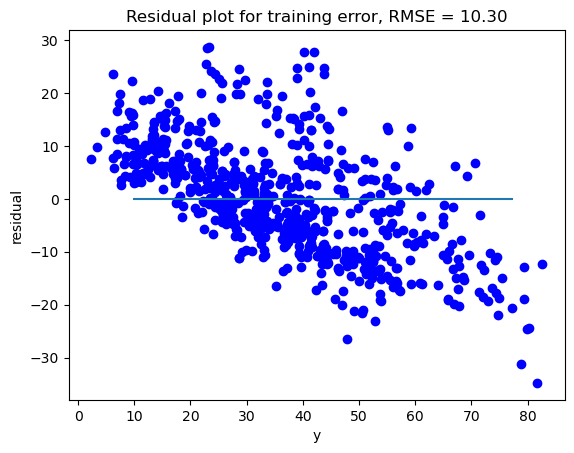

In [23]:
# residual plot for training error
y_pred_train = best_model.predict(sm.add_constant(X_train[best_features]))
res_plot = plt.scatter(y_train, (y_pred_train- y_train), c='b')
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
plt.hlines(y=0, xmin=min(y_pred_train), xmax=max(y_pred_train))
plt.title("Residual plot for training error, RMSE = {:.2f}".format(rmse_train))
plt.xlabel('y')
plt.ylabel('residual')
plt.show()

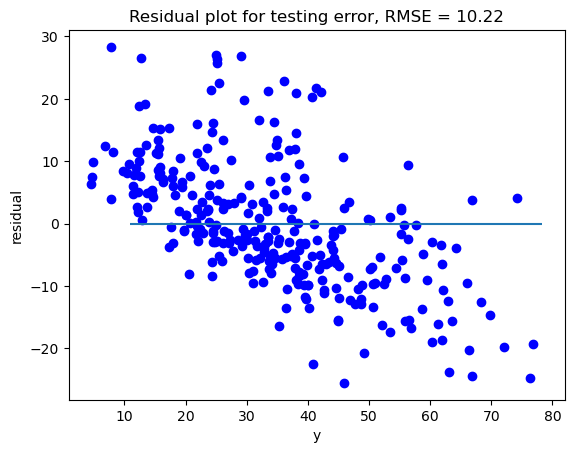

In [24]:
# residual plot for testing error
y_pred_test = best_model.predict(sm.add_constant(X_test[best_features]))
res_plot = plt.scatter(y_test, (y_pred_test- y_test), c='b')
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test))
plt.title("Residual plot for testing error, RMSE = {:.2f}".format(rmse_test))
plt.xlabel('y')
plt.ylabel('residual')
plt.show()

#### Note that the RMSE for the testing data is practically the same as the RMSE of the training data. Therefore the model appears to be robust

# Standardization of predictor variables

In the next sections we will repeat the regression analysis using standardization of the predictor variables.

Multiple linear regression analysis performs best when all numerical features are centered around 0 and have variance of the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

This means it is sometimes important to standardize our features. We do this by subtracting the mean from our observations and then dividing the difference by the standard deviation. This so called standard score $z$ for an observation $x$ is calculated as:

$$z = \frac{(x- \bar x)}{s}$$

where:

- x is an observation in a feature
- $\bar x$ is the mean of that feature
-  s is the standard deviation of that feature.

To avoid [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), the standardization of numerical features should always be performed after data splitting and only from training data. Furthermore, we obtain all necessary statistics for our features (mean and standard deviation) from training data and also use them on test data. Note that we don't standardize our dummy variables, if any (which only have values of 0 or 1).

In [25]:
# scale X_train and X_test

from sklearn.preprocessing import StandardScaler

# note that the scaler for the train and test subsets is based on the train subset
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# convert scaled arrays into pandas dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Copy index from unscaled to scaled dataframes
X_train_scaled.index = X_train.index
X_test_scaled.index = X_test.index

In [27]:
# show the summary stats of the X_train_scaled
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,703.0,-2.097263e-16,1.000712,-1.681921,-0.849741,-0.136309,0.650634,2.445994
slag,703.0,-8.085835e-17,1.000712,-0.863253,-0.863253,-0.585320,0.809556,3.298793
fly_ash,703.0,1.516094e-17,1.000712,-0.856764,-0.856764,-0.856764,0.967721,2.227741
water,703.0,5.559011e-16,1.000712,-2.840738,-0.676228,0.156277,0.493968,3.031347
superplasticizer,703.0,1.010729e-17,1.000712,-1.045959,-1.045959,0.063311,0.660610,4.449193
coarse_aggregate,703.0,6.721350e-16,1.000712,-2.258924,-0.544031,-0.072763,0.717921,2.104235
fine_aggregate,703.0,4.548282e-16,1.000712,-2.176558,-0.645594,0.099199,0.618298,2.821331
age,703.0,-7.075105e-17,1.000712,-0.710516,-0.512365,-0.298972,0.127815,4.837709


## Try stepwise using BIC as the criterion with standardized X

In [28]:
# find the best model that minimizes the criterion
best_features, best_model = stepwise(X_train_scaled, y_train, criterion='BIC', verbose='off', direction='all')


BEST OF ALL POSSIBLE MODELS AFTER REMOVING INSIGNIFICANT PREDICTORS
Best features:  ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'age'] 

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     187.8
Date:                Wed, 14 May 2025   Prob (F-statistic):          7.40e-142
Time:                        16:40:37   Log-Likelihood:                -2637.2
No. Observations:                 703   AIC:                             5288.
Df Residuals:                     696   BIC:                             5320.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>

#### Note  that the same predictors are found in the best model using standardization compared with the previous results without standardization. The condition number with standardization is greatly reduced compared with the previous results without standardization, indicating that potential numerical problems related to different scales of the predicted variables has been corrected. Also the coefficient values for all of the predictors are similar order of magnitude with standardization. Otherwise, the results with standardaziation are practically the same as the results without standardization.

## Check the VIF of the results with standardization

In [29]:
# Variance Inflation Factors of final selected predictor variables
# VIF>5 indicates unacceptable collinearity
# Try dropping predictors that are most correlated with other predictors
# until all VIF values of the predictors are < 5

# import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_ = X[best_features]

# Add a constant for the intercept term
X_ = sm.add_constant(X_)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X_.columns

vif["VIF"] = [variance_inflation_factor(X_.values, i)
                    for i in range(len(X_.columns))]

print('VIF of independent variables included in the final model:')
print('VIF<5 indicates acceptable collinearity')
vif

VIF of independent variables included in the final model:
VIF<5 indicates acceptable collinearity


,Feature,VIF
0,const,164.955992
1,cement,1.841536
2,slag,1.743282
3,fly_ash,2.312505
4,water,1.893423
5,superplasticizer,2.365308
6,age,1.108994


#### Note that the VIF values are the same with standardization compared with the previous results without standardization

## Check the residuals of the best standardized model

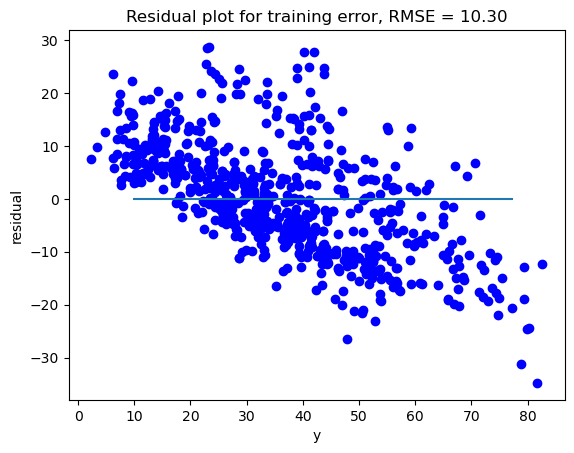

In [30]:
# residual plot for training error
y_pred_train = best_model.predict(sm.add_constant(X_train_scaled[best_features]))
res_plot = plt.scatter(y_train, (y_pred_train- y_train), c='b')
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
plt.hlines(y=0, xmin=min(y_pred_train), xmax=max(y_pred_train))
plt.title("Residual plot for training error, RMSE = {:.2f}".format(rmse_train))
plt.xlabel('y')
plt.ylabel('residual')
plt.show()

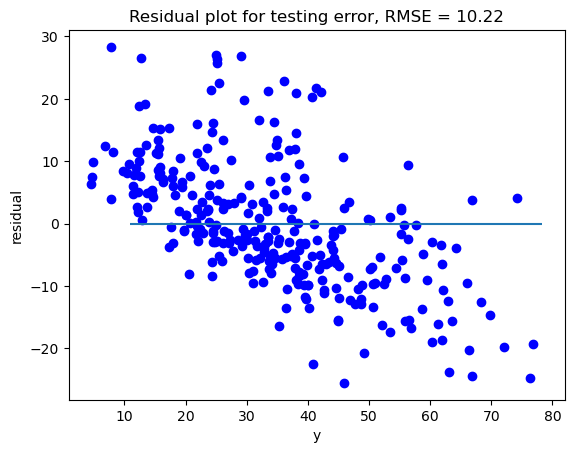

In [31]:
# residual plot for testing error
y_pred_test = best_model.predict(sm.add_constant(X_test_scaled[best_features]))
res_plot = plt.scatter(y_test, (y_pred_test- y_test), c='b')
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test))
plt.title("Residual plot for testing error, RMSE = {:.2f}".format(rmse_test))
plt.xlabel('y')
plt.ylabel('residual')
plt.show()

#### Note that the residual plots and RMSE values are the same using the standardized best model compared with the previous results without standardizing the predictors

# Lasso linear regression

Lasso regression, short for Least Absolute Shrinkage and Selection Operator, is a regression analysis method that performs both variable selection and regularization to enhance the prediction accuracy and interpretability of the resulting statistical model. It is particularly useful when dealing with high-dimensional datasets where multicollinearity is present.

Lasso regression uses a hyper-parameter called "alpha" to fit the optimum set of predictor variables.

REQUIRED INPUTS 
- X = pandas dataframe of the candidate independent variables 
        (as many columns of data as needed)
- y = dependent variable (one column of data)

NOTE: Do any necessary/optional cleaning of the data before 
    passing the data to this function. X and y should have the same number of rows
    and contain only real numbers with no missing values. X can contain as many
    columns as needed, but y should only be one column. X should have unique
    column names for for each column



OPTIONAL KEYWORD ARGUMENTS

**kwargs (optional keyword arguments):
- nfolds= number of folds to use for cross-validation (CV) with k-fold LassoCV or LassoLarsCV (default nfolds=20)
- standardize= 'on' (default) or 'off' where
  - 'on': standardize X using sklearn.preprocessing StandardScaler
  - 'off': do not standardize X
- verbose= 'on' (default) or 'off' where
  - 'on': display model summary on screen 
  - 'off': turn off display of model summary on screen

RETURNS

The following outputs are returned by the **lasso** function:

**model_objects** are the output objects from 
                sklearn.linear_model LassoCV, LassoLarsCV, and LassoLarsIC
                of the final best models using the following four methods: 
- LassoCV: k-fold CV coordinate descent
- LassoLarsCV: k-fold CV least angle regression
- LassoLarsAIC: LassoLarsIC using AIC
- LassoLarsBIC: LasspLarsIC using BIC

**model_outputs** is a dictionary of the following outputs:
                from the four Lasso linear regression model methods:
- 'scaler': sklearn.preprocessing StandardScaler for X
- 'standardize': 'on' scaler was used for X, 'off' scaler not used
- 'alpha_vs_coef': model coefficients for each X variable
                    as a function of alpha using Lasso
- 'alpha_vs_AIC_BIC': AIC and BIC as a function of alpha 
                    using LassoLarsIC
- 'stats': Regression statistics for each model
- 'popt': Constant (intercept) and coefficients for the 
                    best fit models from each of the four methods
- 'y_pred': Predicted y values for each of the four methods
- 'residuals': Residuals (y-y_pred) for each of the four methods


Fitting Lasso regression models, please wait ...


Lasso regression statistics of best models in model_outputs['stats']:


| Statistic          |         LassoCV |     LassoLarsCV |    LassoLarsAIC |    LassoLarsBIC |
|:-------------------|----------------:|----------------:|----------------:|----------------:|
| alpha              |     0.00872469  |     0           |     0           |     0.156637    |
| r-squared          |     0.621693    |     0.621722    |     0.621722    |     0.616996    |
| adjusted r-squared |     0.61678     |     0.616809    |     0.616809    |     0.613138    |
| nobs               |   703           |   703           |   703           |   703           |
| df residuals       |   694           |   694           |   694           |   696           |
| df model           |     8           |     8           |     8           |     6           |
| F-statistic        |   142.561       |   142.579       |   142.579       |   186.869       |
| Prob (F-statistic) |

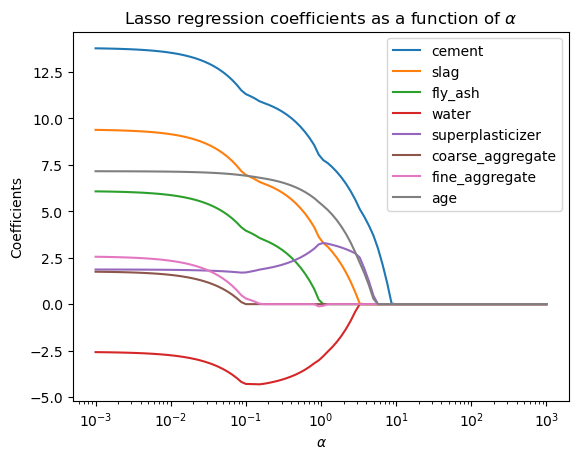

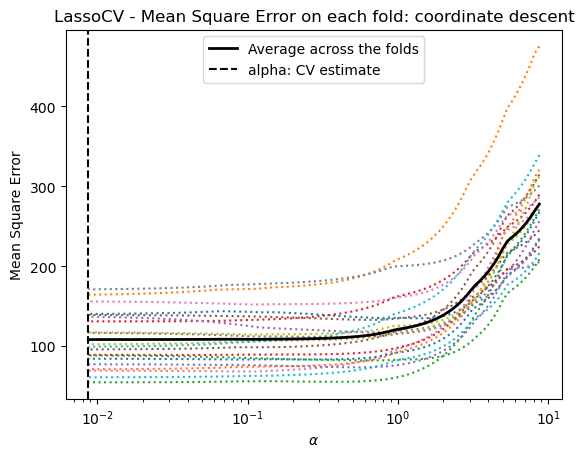

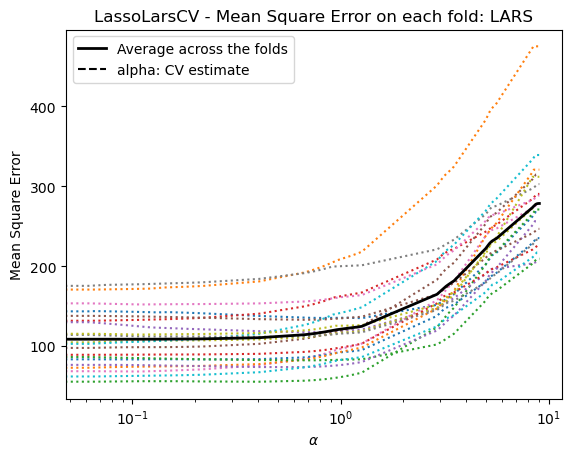

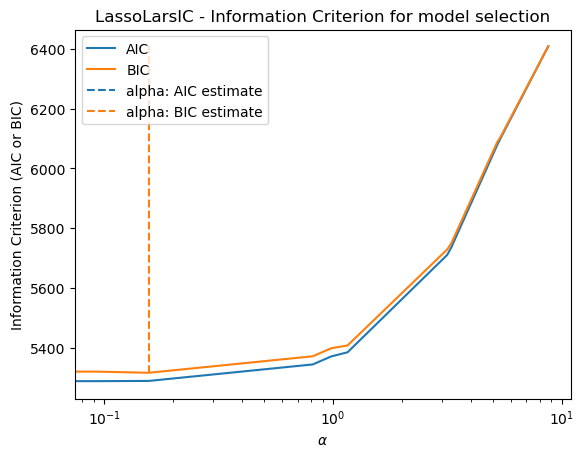

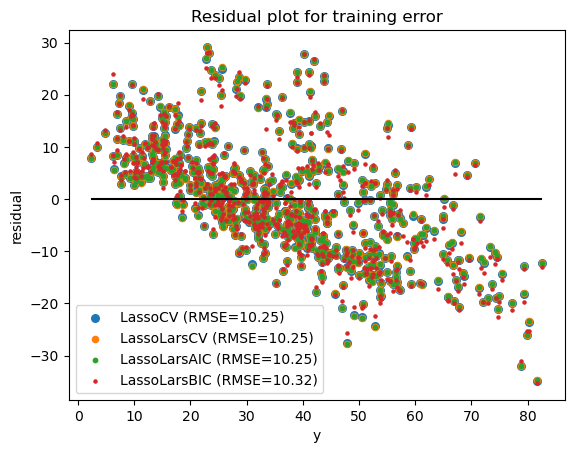

In [32]:
model_objects, model_outputs = lasso(X_train, y_train)

#### Note that the LassoCV, LassoLarsCV, and LassoLarsAIC models did not eliminate any of the candidate predictors, therefore these methods result in excessive collinearity of features as shown above in the stepwise analysis using AIC. The LassoLarsBIC model finds the same best features as the previous stepwise method using BIC, therefore this model has acceptable collinearity as shown above in the stepwise section. The model skill from Lasso regression is similar to the skill of the models from stepwise regression.

## Check the residuals of the best model using the test data subset

The best result from trained Lasso regession is the model using LassoLarsIC with BIC as the criterion (LassoLarsBIC). In the next sections we will show how to look at the residuals of test data subset using the LassoLarsBIC model that was trained with the training data subset.

First, we will extract the scalar that was used to standardize the X values of training data subset from the output of the trained model, and use it to standardize the X values of the test data subset. 

In [33]:
# Extract the scaler that was used to standardize the X_train values
scaler = model_outputs['scaler']

# Normalize X_test using the same scaler that was used on X_train
X_test_scaled = scaler.transform(X_test)

# Convert scaled array into pandas dataframe with same column names as X
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Copy index from unscaled to scaled dataframes
X_test_scaled.index = X_test.index

Next we will extract the fitted model object for the best fit model using LassoLarsIC with BIC and use it to estimate predicted y values from  the test data.

In [34]:
# extract the trained model object of the best fit using LassoLarsIC with BIC
model = model_objects['LassoLarsBIC']

# use the trained LassoLarsBIC model to predict y_pred for the normalized test data subset
y_pred_test = model.predict(X_test_scaled) 

Finally we will plot the residuals for the predicted y values using the test data subset

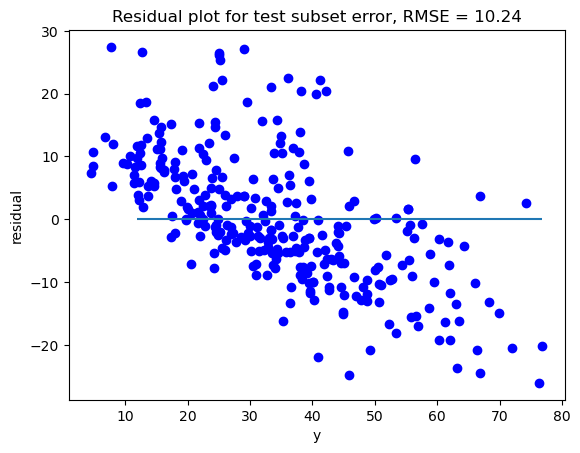

In [35]:
# residual plot for training error
res_plot = plt.scatter(y_test, (y_pred_test - y_test), c='b')
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test))
plt.title("Residual plot for test subset error, RMSE = {:.2f}".format(rmse_test))
plt.xlabel('y')
plt.ylabel('residual')
plt.show()

# Conclusion

The results of LassoCV, LassoLarsCV, and LassoLarsAIC are all very similar to the previous stepwise results using AIC as the criterion. Each of these models is problematic because they include too many features with excessive multi-collinearity. In other words, using Lasso regression does not necessarily guarantee that the model will be acceptable in terms of parsimonious trade-offs between skill and collinearity

The results from LassoLarsBIC are similar to the previous stepwise results using BIC as the criterion. Both of these methods select the same features as the optimum model. The optimum models using either stepwise regression with BIC or LassoLarsIC with BIC are both acceptable alternatives with similar model skill and acceptable magnitude of collinearity of predictor variables.

